# Lab 4 Sample Code

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random
import csv

def sigmoid(x):
    """Sigmoid function.
    This function accepts any shape of np.ndarray object as input and perform sigmoid operation.
    """
    # limit the range to prevent overflow
    x = np.clip(x, -1000, 1000)  
    return 1 / (1 + np.exp(-x))


def der_sigmoid(y):
    """First derivative of Sigmoid function.
    The input to this function should be the value that output from sigmoid function.
    """
    return y * (1 - y)


class GenData:
    @staticmethod
    def _gen_linear(n=100):
        """Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:, 0], pos[:, 1]
        return pos, (x > y).astype(np.int64).reshape((-1, 1))

    @staticmethod
    def _gen_xor(n=100):
        """Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace(0, 1, n // 2)

        inputs = []
        labels = []

        for x in data_x:
            inputs.append([x, x])
            labels.append(0)

            if x == 1 - x:
                continue

            inputs.append([x, 1 - x])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def _gen_chessboard(n=100):
        """Data generation (Chessboard)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:, 0], pos[:, 1]
        return pos, ((x < 0.25) ^ (x > 0.5) ^ (x > 0.75) ^ (y < 0.25) ^ (y > 0.5) ^ (y > 0.75)).astype(np.int64).reshape(
            (-1, 1)
        )

    @staticmethod
    def fetch_data(mode, n):
        """Data gather interface

        Args:
            mode (str): 'Linear' or 'XOR', indicate which generator is used.
            n (int):    the number of data points generated in total.
        """
        assert mode == "Linear" or mode == "XOR" or mode == "Chessboard"

        data_gen_func = {"Linear": GenData._gen_linear, "XOR": GenData._gen_xor, "Chessboard": GenData._gen_chessboard}[mode]

        return data_gen_func(n)


class SimpleNet:
    def __init__(self, num_step=6000, print_interval=100, learning_rate=None, patience=None, early_stop=None, decay_rate=None, log_file=None, beta1=0.9, beta2=0.999, epsilon=1e-8):  # don't change print_interval
        self.num_step = num_step
        self.print_interval = print_interval
        self.learning_rate = learning_rate
        self.patience = patience  # apdative learning rate patience
        self.decay_rate = decay_rate  # apdative learning rate decay rate
        self.best_val_accuracy = 0  
        self.no_improvement_count = 0  
        # self.log_file = log_file
        self.early_stop = early_stop
        self.beta1 = beta1  # for calculating momentum
        self.beta2 = beta2  # for calculating RMSprop
        self.epsilon = epsilon  # prevent division by zero

        # if self.log_file is not None:
        #     with open(self.log_file, mode='w', newline='') as file:
        #         writer = csv.writer(file)
        #         writer.writerow(['Epoch', 'Training Accuracy', 'Validation Accuracy'])

        # set random seed
        seed = 87 
        np.random.seed(seed)
        random.seed(seed)        

        # Model parameters initialization
        self.hidden1_weights = np.random.randn(100, 2) 
        self.hidden2_weights = np.random.randn(50, 100) 
        self.hidden3_weights = np.random.randn(10, 50) 
        self.output_weights = np.random.randn(1, 10) 

        self.hidden1_bias = np.zeros((100, 1))
        self.hidden2_bias = np.zeros((50, 1))
        self.hidden3_bias = np.zeros((10, 1))
        self.output_bias = np.zeros((1, 1))

        # momentum & RMSprop initialization
        self.m_dW1 = np.zeros_like(self.hidden1_weights)
        self.m_dW2 = np.zeros_like(self.hidden2_weights)
        self.m_dW3 = np.zeros_like(self.hidden3_weights)
        self.m_dW_out = np.zeros_like(self.output_weights)

        self.v_dW1 = np.zeros_like(self.hidden1_weights)
        self.v_dW2 = np.zeros_like(self.hidden2_weights)
        self.v_dW3 = np.zeros_like(self.hidden3_weights)
        self.v_dW_out = np.zeros_like(self.output_weights)

        self.m_db1 = np.zeros_like(self.hidden1_bias)
        self.m_db2 = np.zeros_like(self.hidden2_bias)
        self.m_db3 = np.zeros_like(self.hidden3_bias)
        self.m_db_out = np.zeros_like(self.output_bias)

        self.v_db1 = np.zeros_like(self.hidden1_bias)
        self.v_db2 = np.zeros_like(self.hidden2_bias)
        self.v_db3 = np.zeros_like(self.hidden3_bias)
        self.v_db_out = np.zeros_like(self.output_bias)


    def adjust_learning_rate(self, val_accuracy):
        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.learning_rate *= self.decay_rate
                self.no_improvement_count = 0
                

    @staticmethod
    def plot_result(data, gt_y, pred_y):
        """Data visualization with ground truth and predicted data comparison. There are two plots
        for them and each of them use different colors to differentiate the data with different labels.

        Args:
            data:   the input data
            gt_y:   ground truth to the data
            pred_y: predicted results to the data
        """
        assert data.shape[0] == gt_y.shape[0] == pred_y.shape[0], f"{data.shape}, {gt_y.shape}, {pred_y.shape}"

        plt.figure(figsize=(11, 5))

        plt.subplot(121)
        plt.title("Ground Truth", fontsize=18)
        plt.scatter(data[:,0], data[:,1], c=gt_y[:,0], cmap=plt.cm.bwr)

        plt.subplot(122)
        plt.title("Prediction", fontsize=18)
        plt.scatter(data[:,0], data[:,1], c=pred_y[:,0], cmap=plt.cm.bwr)

        plt.show()

    def forward(self, inputs):
        # transpose inputs
        inputs = inputs.T  
        # hidden layer 1
        self.z1 = np.dot(self.hidden1_weights, inputs) + self.hidden1_bias
        self.a1 = sigmoid(self.z1)

        # hidden layer 2
        self.z2 = np.dot(self.hidden2_weights, self.a1) + self.hidden2_bias
        self.a2 = sigmoid(self.z2)

        # hidden layer 3
        self.z3 = np.dot(self.hidden3_weights, self.a2) + self.hidden3_bias
        self.a3 = sigmoid(self.z3)

        # output layer
        self.z_out = np.dot(self.output_weights, self.a3) + self.output_bias
        self.a_out = sigmoid(self.z_out)

        return self.a_out.T#

    def backward(self, inputs, labels, t):
        m = inputs.shape[0]  # batch size

        # compute derivative of loss
        dz_out = (self.a_out - labels)  # prediction error
        dW_out = np.dot(dz_out, self.a3.T) / m
        db_out = np.sum(dz_out, axis=1, keepdims=True) / m

        # Backpropagate to hidden layer 3
        dz3 = np.dot(self.output_weights.T, dz_out) * der_sigmoid(self.a3)
        dW3 = np.dot(dz3, self.a2.T) / m
        db3 = np.sum(dz3, axis=1, keepdims=True) / m

        # Backpropagate to hidden layer 2
        dz2 = np.dot(self.hidden3_weights.T, dz3) * der_sigmoid(self.a2)
        dW2 = np.dot(dz2, self.a1.T) / m
        db2 = np.sum(dz2, axis=1, keepdims=True) / m

        # Backpropagate to hidden layer 1
        dz1 = np.dot(self.hidden2_weights.T, dz2) * der_sigmoid(self.a1)
        dW1 = np.dot(dz1, inputs) / m
        db1 = np.sum(dz1, axis=1, keepdims=True) / m

        # first order momentum (m)
        self.m_dW_out = self.beta1 * self.m_dW_out + (1 - self.beta1) * dW_out
        self.m_dW3 = self.beta1 * self.m_dW3 + (1 - self.beta1) * dW3
        self.m_dW2 = self.beta1 * self.m_dW2 + (1 - self.beta1) * dW2
        self.m_dW1 = self.beta1 * self.m_dW1 + (1 - self.beta1) * dW1

        self.m_db_out = self.beta1 * self.m_db_out + (1 - self.beta1) * db_out
        self.m_db3 = self.beta1 * self.m_db3 + (1 - self.beta1) * db3
        self.m_db2 = self.beta1 * self.m_db2 + (1 - self.beta1) * db2
        self.m_db1 = self.beta1 * self.m_db1 + (1 - self.beta1) * db1

        # second order momentum (v)
        self.v_dW_out = self.beta2 * self.v_dW_out + (1 - self.beta2) * dW_out**2
        self.v_dW3 = self.beta2 * self.v_dW3 + (1 - self.beta2) * dW3**2
        self.v_dW2 = self.beta2 * self.v_dW2 + (1 - self.beta2) * dW2**2
        self.v_dW1 = self.beta2 * self.v_dW1 + (1 - self.beta2) * dW1**2

        self.v_db_out = self.beta2 * self.v_db_out + (1 - self.beta2) * db_out**2
        self.v_db3 = self.beta2 * self.v_db3 + (1 - self.beta2) * db3**2
        self.v_db2 = self.beta2 * self.v_db2 + (1 - self.beta2) * db2**2
        self.v_db1 = self.beta2 * self.v_db1 + (1 - self.beta2) * db1**2

        # correct bias
        m_dW_out_corr = self.m_dW_out / (1 - self.beta1**t)
        m_dW3_corr = self.m_dW3 / (1 - self.beta1**t)
        m_dW2_corr = self.m_dW2 / (1 - self.beta1**t)
        m_dW1_corr = self.m_dW1 / (1 - self.beta1**t)

        m_db_out_corr = self.m_db_out / (1 - self.beta1**t)
        m_db3_corr = self.m_db3 / (1 - self.beta1**t)
        m_db2_corr = self.m_db2 / (1 - self.beta1**t)
        m_db1_corr = self.m_db1 / (1 - self.beta1**t)

        v_dW_out_corr = self.v_dW_out / (1 - self.beta2**t)
        v_dW3_corr = self.v_dW3 / (1 - self.beta2**t)
        v_dW2_corr = self.v_dW2 / (1 - self.beta2**t)
        v_dW1_corr = self.v_dW1 / (1 - self.beta2**t)

        v_db_out_corr = self.v_db_out / (1 - self.beta2**t)
        v_db3_corr = self.v_db3 / (1 - self.beta2**t)
        v_db2_corr = self.v_db2 / (1 - self.beta2**t)
        v_db1_corr = self.v_db1 / (1 - self.beta2**t)

        # update weights and bias
        self.output_weights -= self.learning_rate * m_dW_out_corr / (np.sqrt(v_dW_out_corr) + self.epsilon)
        self.output_bias -= self.learning_rate * m_db_out_corr / (np.sqrt(v_db_out_corr) + self.epsilon)
        self.hidden3_weights -= self.learning_rate * m_dW3_corr / (np.sqrt(v_dW3_corr) + self.epsilon)
        self.hidden3_bias -= self.learning_rate * m_db3_corr / (np.sqrt(v_db3_corr) + self.epsilon)
        self.hidden2_weights -= self.learning_rate * m_dW2_corr / (np.sqrt(v_dW2_corr) + self.epsilon)
        self.hidden2_bias -= self.learning_rate * m_db2_corr / (np.sqrt(v_db2_corr) + self.epsilon)
        self.hidden1_weights -= self.learning_rate * m_dW1_corr / (np.sqrt(v_dW1_corr) + self.epsilon)
        self.hidden1_bias -= self.learning_rate * m_db1_corr / (np.sqrt(v_db1_corr) + self.epsilon)

    def train(self, inputs, labels, val_data, val_labels, test_data, test_labels):      
        best_val_accuracy = 0  
        no_improvement_count = 0 
        t = 1  # adam step counter
        # make sure that the amount of data and label is match
        assert inputs.shape[0] == labels.shape[0]

        n = inputs.shape[0]

        for epochs in range(self.num_step):
            for idx in range(n): 
                input_sample = inputs[idx : idx + 1, :]
                label_sample = labels[idx : idx + 1, :]
                self.output = self.forward(input_sample)
                self.backward(input_sample, label_sample, t)
                t += 1 

            if epochs % self.print_interval == 0:
                print("Epochs {}: Train ".format(epochs), end="")
                train_accuracy = self.test(inputs, labels)
                val_accuracy = self.evaluate(val_data, val_labels)
                print(f"Validation accuracy: {val_accuracy:.2f}%")
                print('-------------------------------')
               
                # if self.log_file is not None:
                #     with open(self.log_file, mode='a', newline='') as file:
                #         writer = csv.writer(file)
                #         writer.writerow([epochs, train_accuracy, val_accuracy])

                # Early Stopping 
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy 
                    no_improvement_count = 0 
                else:
                    no_improvement_count += 1  

                if no_improvement_count >= self.early_stop:
                    print(f"Early stopping at epoch {epochs} due to no improvement in validation accuracy.")
                    break        

                self.adjust_learning_rate(val_accuracy) 
                           
        print("Training finished")
        self.test(test_data, test_labels)


    def test(self, inputs, labels):
        n = inputs.shape[0]

        error = 0.0
        for idx in range(n):
            result = self.forward(inputs[idx : idx + 1, :])
            error += abs(result - labels[idx : idx + 1, :])

        error /= n
        error = error.item()
        print("accuracy: %.2f" % ((1 - error) * 100) + "%")


    def evaluate(self, inputs, labels):
        n = inputs.shape[0]
        correct = 0
        for idx in range(n):
            result = np.round(self.forward(inputs[idx:idx + 1, :]))
            if result == labels[idx:idx + 1, :]:
                correct += 1
        return (correct / n) * 100

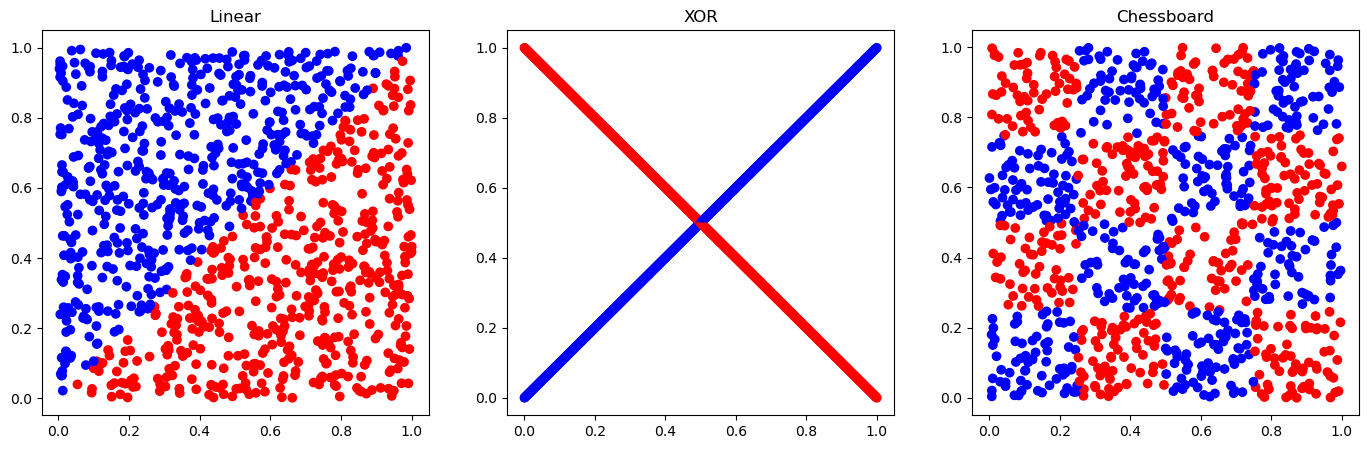

In [7]:
plt.figure(figsize=(17, 5))
for i, name in enumerate(['Linear', 'XOR', 'Chessboard']):
    data, label = GenData.fetch_data(name, 1000)
    plt.subplot(1,3,i+1)
    plt.scatter(data[:, 0], data[:, 1], c=label[:, 0], cmap=plt.cm.bwr)
    plt.title(name)

### Run "Linear"

Epochs 0: Train accuracy: 85.87%
Validation accuracy: 94.44%
-------------------------------
Epochs 100: Train accuracy: 97.42%
Validation accuracy: 98.89%
-------------------------------
Epochs 200: Train accuracy: 98.40%
Validation accuracy: 98.89%
-------------------------------
Epochs 300: Train accuracy: 98.16%
Validation accuracy: 98.89%
-------------------------------
Epochs 400: Train accuracy: 98.13%
Validation accuracy: 98.89%
-------------------------------
Epochs 500: Train accuracy: 98.15%
Validation accuracy: 98.89%
-------------------------------
Epochs 600: Train accuracy: 98.24%
Validation accuracy: 98.89%
-------------------------------
Epochs 700: Train accuracy: 96.30%
Validation accuracy: 94.44%
-------------------------------
Epochs 800: Train accuracy: 96.95%
Validation accuracy: 98.89%
-------------------------------
Epochs 900: Train accuracy: 98.38%
Validation accuracy: 98.89%
-------------------------------
Epochs 1000: Train accuracy: 98.08%
Validation accur

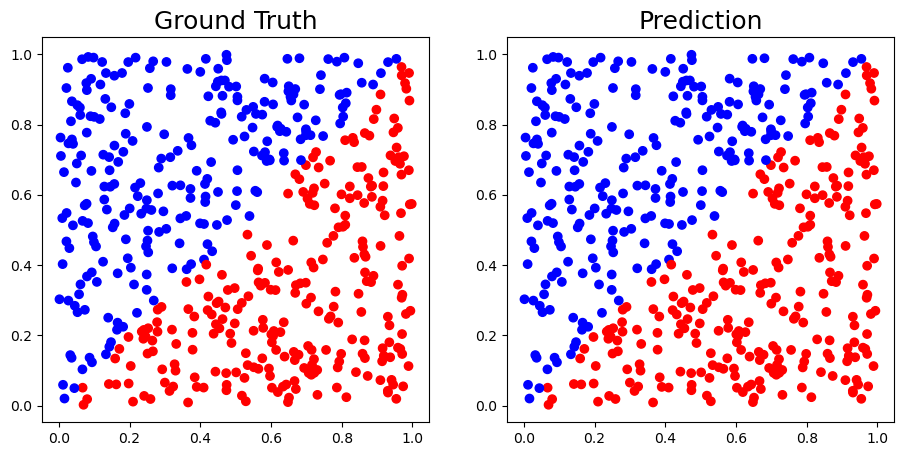

In [8]:
data, label = GenData.fetch_data("Linear", 500)
train_data, test_data, train_labels, test_labels = train_test_split(data, label, test_size=0.1, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

net = SimpleNet(4000,learning_rate=1e-2,patience=20, early_stop=10, decay_rate=0.8)
net.train(train_data, train_labels, val_data, val_labels, test_data, test_labels)

pred_result = np.round(net.forward(data))
SimpleNet.plot_result(data, label, pred_result)

### Run "XOR"

Epochs 0: Train accuracy: 54.73%
Validation accuracy: 72.22%
-------------------------------
Epochs 100: Train accuracy: 95.54%
Validation accuracy: 98.89%
-------------------------------
Epochs 200: Train accuracy: 98.02%
Validation accuracy: 98.89%
-------------------------------
Epochs 300: Train accuracy: 97.80%
Validation accuracy: 97.78%
-------------------------------
Epochs 400: Train accuracy: 98.74%
Validation accuracy: 98.89%
-------------------------------
Epochs 500: Train accuracy: 98.57%
Validation accuracy: 98.89%
-------------------------------
Epochs 600: Train accuracy: 98.88%
Validation accuracy: 98.89%
-------------------------------
Epochs 700: Train accuracy: 99.13%
Validation accuracy: 98.89%
-------------------------------
Epochs 800: Train accuracy: 99.24%
Validation accuracy: 100.00%
-------------------------------
Epochs 900: Train accuracy: 99.27%
Validation accuracy: 100.00%
-------------------------------
Epochs 1000: Train accuracy: 99.32%
Validation acc

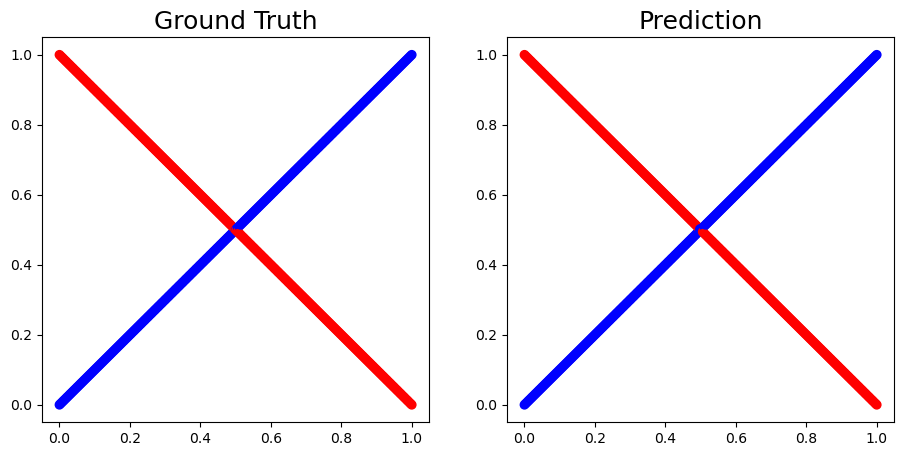

In [4]:
data, label = GenData.fetch_data("XOR", 500)
train_data, test_data, train_labels, test_labels = train_test_split(data, label, test_size=0.1, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

net = SimpleNet(4000,learning_rate=1e-3,patience=5, early_stop=10, decay_rate=0.4)
net.train(train_data, train_labels, val_data, val_labels, test_data, test_labels)

pred_result = np.round(net.forward(data))
SimpleNet.plot_result(data, label, pred_result)

### Run "Chessboard"

Epochs 0: Train accuracy: 50.17%
Validation accuracy: 50.28%
-------------------------------
Epochs 100: Train accuracy: 87.43%
Validation accuracy: 92.78%
-------------------------------
Epochs 200: Train accuracy: 90.77%
Validation accuracy: 92.78%
-------------------------------
Epochs 300: Train accuracy: 92.17%
Validation accuracy: 92.50%
-------------------------------
Epochs 400: Train accuracy: 93.38%
Validation accuracy: 93.61%
-------------------------------
Epochs 500: Train accuracy: 94.12%
Validation accuracy: 93.61%
-------------------------------
Epochs 600: Train accuracy: 94.73%
Validation accuracy: 94.44%
-------------------------------
Epochs 700: Train accuracy: 94.77%
Validation accuracy: 94.72%
-------------------------------
Epochs 800: Train accuracy: 94.67%
Validation accuracy: 94.72%
-------------------------------
Epochs 900: Train accuracy: 94.67%
Validation accuracy: 94.17%
-------------------------------
Epochs 1000: Train accuracy: 94.96%
Validation accur

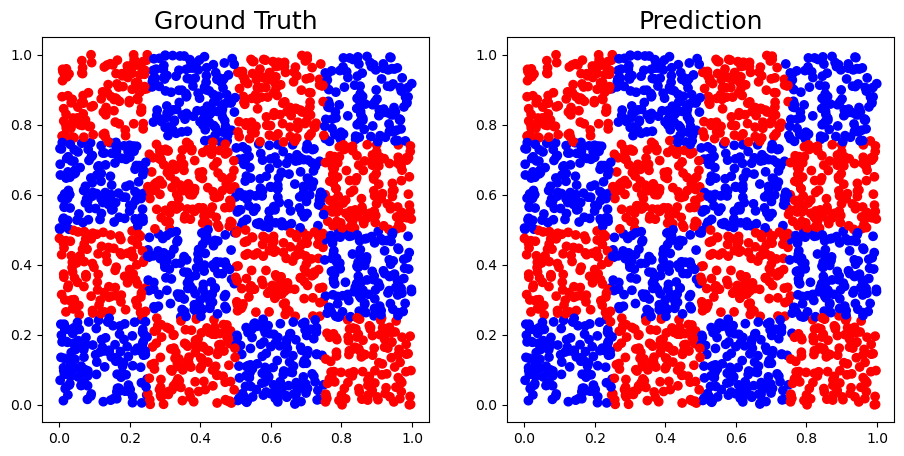

In [3]:
data, label = GenData.fetch_data("Chessboard", 2000)
train_data, test_data, train_labels, test_labels = train_test_split(data, label, test_size=0.1, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

net = SimpleNet(10000,learning_rate=1e-3,patience=5, early_stop=15, decay_rate=0.4)
net.train(train_data, train_labels, val_data, val_labels, test_data, test_labels)

pred_result = np.round(net.forward(data))
SimpleNet.plot_result(data, label, pred_result)